In [30]:
import json
import geojson
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [31]:
with open('intermediate_file_paths.json') as output_path_file:
    output_paths = json.load(output_path_file)

SI_PER_FIRE_INPUT_PATH = output_paths.get('stage1_si_per_fire_csv')
SCALED_SI_PER_YEAR_INPUT_PATH = output_paths.get('stage2_scaled_si_per_year_csv')

# Load dataset
yearly_smoke_impact_df = pd.read_csv(SCALED_SI_PER_YEAR_INPUT_PATH)
si_per_fire_df = pd.read_csv(SI_PER_FIRE_INPUT_PATH)

In [32]:
print(yearly_smoke_impact_df.columns)

Index(['year', 'fire_year', 'total_amortized_smoke_impact',
       'total_fire_duration', 'total_acres_burned', 'avg_daily_smoke_impact',
       'scaled_avg_daily_smoke_impact'],
      dtype='object')


In [33]:
print(si_per_fire_df.columns)

Index(['OBJECTID', 'USGS_Assigned_ID', 'Assigned_Fire_Type', 'fire_year',
       'Fire_Polygon_Tier', 'Fire_Attribute_Tiers', 'total_acres_burned',
       'GIS_Hectares', 'Source_Datasets', 'Listed_Fire_Types',
       'Listed_Fire_Names', 'Listed_Fire_Codes', 'Listed_Fire_IDs',
       'Listed_Fire_IRWIN_IDs', 'Listed_Fire_Dates', 'Listed_Fire_Causes',
       'Listed_Fire_Cause_Class', 'Listed_Rx_Reported_Acres',
       'Listed_Map_Digitize_Methods', 'Listed_Notes', 'Processing_Notes',
       'Wildfire_Notice', 'Prescribed_Burn_Notice', 'Wildfire_and_Rx_Flag',
       'Overlap_Within_1_or_2_Flag', 'Circleness_Scale', 'Circle_Flag',
       'Exclude_From_Summary_Rasters', 'Shape_Length', 'Shape_Area',
       'distance', 'smoke_impact', 'fire_duration', 'amortized_smoke_impact'],
      dtype='object')


In [36]:
# Define weights for 'total_acres_burned' and 'distance'
weights = {'total_acres_burned': 1, 'distance': 1}

# Calculate the average distance per year
avg_dist_df = si_per_fire_df.groupby('fire_year').agg(
    avg_dist_from_city=('distance', 'mean')
).reset_index()

# Filter data to include only years after 1984
yearly_smoke_impact_filtered_df = yearly_smoke_impact_df[yearly_smoke_impact_df['year'] > 1984]
filtered_avg_dist_df = avg_dist_df[avg_dist_df['fire_year'] > 1984]

# Prepare data for prediction using original data (without moving average)
combined_df = yearly_smoke_impact_filtered_df[['scaled_avg_daily_smoke_impact', 'year', 'total_acres_burned']].merge(
    filtered_avg_dist_df[['fire_year', 'avg_dist_from_city']],
    left_on='year', right_on='fire_year', how='left'
)

# Apply weights to the relevant predictor variables
combined_df['total_acres_burned_weighted'] = combined_df['total_acres_burned'] * weights['total_acres_burned']
combined_df['distance_weighted'] = combined_df['avg_dist_from_city'] * weights['distance']

# Identify which years have NaN values
na_years = combined_df[combined_df.isna().any(axis=1)]['year'].unique()
print(f"Years with NaN values: {na_years}")

# Remove rows with NaN values in features or labels
combined_df = combined_df.dropna()

# Prepare the features and target variable
features = combined_df[['total_acres_burned_weighted', 'distance_weighted']].values
labels = combined_df['scaled_avg_daily_smoke_impact'].values

Years with NaN values: [2021]


In [29]:
print(combined_df.columns)

Index(['scaled_avg_daily_smoke_impact', 'year', 'total_acres_burned',
       'fire_year', 'avg_dist_from_city', 'total_acres_burned_weighted',
       'distance_weighted'],
      dtype='object')


Mean Squared Error (MSE) for 1984-2021: 137.85891985303573
R-squared (R2) Score for 1984-2021: -0.5887154960506817


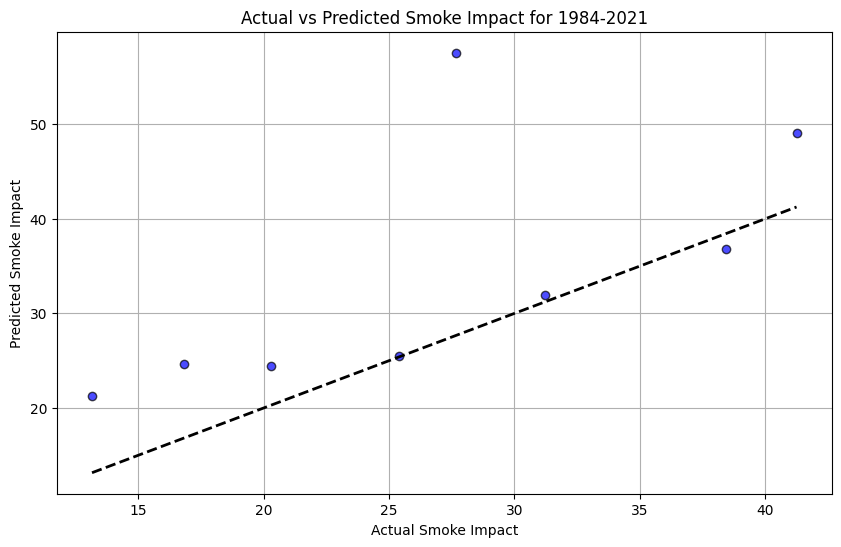

In [39]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

# Create and train the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict smoke estimates for the test set
y_pred = model.predict(X_test)

# Calculate metrics for model evaluation
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE) for 1984-2021: {mse}")
print(f"R-squared (R2) Score for 1984-2021: {r2}")

# Plotting the actual vs predicted smoke impact for the test set
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='blue', edgecolors='k', alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual Smoke Impact')
plt.ylabel('Predicted Smoke Impact')
plt.title('Actual vs Predicted Smoke Impact for 1984-2021')
plt.grid(True)
plt.show()